In [81]:
import geopandas as gpd
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import plotly.express as px
%matplotlib inline
import types
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from time import time
from pandas import to_datetime
from fbprophet import Prophet


import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')


## Collection events

In [42]:
#waste_aust = pd.read_csv(r'C:\Users\fredericorodrigues\Downloads\waste_collection.csv')  
waste_aust = pd.read_csv('data/waste_collection.csv')  

In [43]:
waste_aust.dtypes

Report Date      object
Load Type        object
Load Time        object
Load Weight     float64
Dropoff Site     object
Route Type       object
Route Number     object
Load ID           int64
dtype: object

In [44]:
waste_aust['Load Time'] = pd.to_datetime(waste_aust['Load Time'])
waste_aust['Report Date'] = pd.to_datetime(waste_aust['Report Date'])

In [45]:
cal = calendar()
holidays = cal.holidays(start=waste_aust['Load Time'].min(), end=waste_aust['Load Time'].max())

waste_aust['Holiday'] = waste_aust['Load Time'].isin(holidays)

In [46]:
waste_aust['DoW'] = waste_aust['Load Time'].dt.day_name()

waste_aust.head()

Report Date                  Load Type           Load Time  Load Weight  \
0  2020-12-08                       BULK 2020-12-08 15:02:00       5220.0   
1  2020-12-08  RECYCLING - SINGLE STREAM 2020-12-08 10:00:00      11140.0   
2  2020-12-03  RECYCLING - SINGLE STREAM 2020-12-03 10:34:00      10060.0   
3  2020-12-07                   SWEEPING 2020-12-07 10:15:00       7100.0   
4  2020-12-07  RECYCLING - SINGLE STREAM 2020-12-07 16:00:00      12000.0   

         Dropoff Site                 Route Type Route Number  Load ID  \
0        TDS LANDFILL                       BULK         BU13   899097   
1           TDS - MRF  RECYCLING - SINGLE STREAM       RTAU53   899078   
2  BALCONES RECYCLING  RECYCLING - SINGLE STREAM       RHBU10   899082   
3        TDS LANDFILL          SWEEPER DUMPSITES        DSS04   899030   
4           TDS - MRF  RECYCLING - SINGLE STREAM       RMAU53   899048   

   Holiday       DoW  
0    False   Tuesday  
1    False   Tuesday  
2    False  Thursday  
3    False    Monday  
4    False    Monday

In [47]:
waste_aust.Holiday= waste_aust.Holiday.apply(lambda x : 0 if x == False else 1 )
waste_aust['Weekend'] = waste_aust.DoW.apply(lambda x : 1 if x == 'Sunday' or x == 'Saturday' else 0)

In [57]:
waste = waste_aust[['Report Date','Load Weight','Weekend','Holiday']].copy()
waste = waste.groupby(['Report Date']).agg({'Load Weight': 'sum','Holiday': 'max','Weekend': 'max'})

waste.head()

Load Weight  Holiday  Weekend
Report Date                               
2003-01-13       20170.0        0        0
2004-08-25      139140.0        0        0
2004-08-26       61480.0        0        0
2004-08-30       13160.0        0        0
2004-09-28      120740.0        0        0

### Forecast - SARIMAX with Exogenous Variables

In [58]:
weather = pd.read_csv('data/weather.csv')

weather['date']= pd.to_datetime(weather['date'], infer_datetime_format=True)

weather.head()

date  tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun
0 2015-01-01   3.1   1.7   3.9  10.4     0   NaN  17.3   NaN     NaN   NaN
1 2015-01-02   4.2   3.3   5.6   3.6     0   0.0  15.5   NaN  1019.3   NaN
2 2015-01-03   6.6   1.1  15.6  16.0     0   NaN   6.5   NaN  1015.9   NaN
3 2015-01-04   6.0  -1.6  10.6   0.0     0   NaN  18.7   NaN  1031.0   NaN
4 2015-01-05   1.9  -4.3  10.6   0.0     0   NaN   9.0   NaN  1036.4   NaN

In [64]:
weather.columns

Index(['date', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt',
       'pres', 'tsun'],
      dtype='object')

In [181]:
df = waste.reset_index().merge(weather, left_on='Report Date', right_on='date')[['Report Date','Load Weight','Weekend','Holiday','tavg', 'tmin', 'tmax', 'prcp', 'snow','wspd']]

In [182]:
exogvar =  df.columns.drop(['Report Date', 'Load Weight'])
exogvar

Index(['Weekend', 'Holiday', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd'], dtype='object')

In [183]:
df.isna().sum()

Report Date    0
Load Weight    0
Weekend        0
Holiday        0
tavg           0
tmin           0
tmax           0
prcp           0
snow           0
wspd           0
dtype: int64

In [184]:
df['Report Date']  = pd.to_datetime(df['Report Date'], format='%Y-%m-%d')

In [185]:
train_start = datetime(2010,2,1)
train_end = datetime(2020,7,30)
test_end = datetime(2020,8,31)

df = df.set_index('Report Date')

train_data = df[train_start:train_end]
test_data = df[train_end + timedelta(days=1):test_end]

In [186]:
def visualizedata(df,column):
    fig = px.line(x=df.index, y=df[column], labels={'x':'Report Date', 'y':column})
    fig.show()
visualizedata(df,'Load Weight')

In [187]:
# Augmented Dickey-Fuller Test - Checking Stationarity
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

perform_adf_test(df['Load Weight'])

ADF Statistic: -5.779286
p-value: 0.000001


In [188]:
first_diff = df['Load Weight'].diff()[1:]
first_diff = pd.Series(first_diff,index=df['Load Weight'].iloc[1:].index)
perform_adf_test(first_diff)

ADF Statistic: -15.396381
p-value: 0.000000


In [189]:
acf_vals = acf(first_diff)
fig = px.bar(y=acf_vals)
fig.show()

In [190]:
pacf_vals = pacf(first_diff)
fig = px.bar(y=pacf_vals)
fig.show()

In [191]:
#sm.tsa.SARIMAX(df['Climate_Change'], order=(1,1,1))
my_order = (1,0,1) #(p,d,q) (AR,I,MA)
my_seasonal_order = (1, 1, 1, 7) #
trend = 'n'
'''A parameter for controlling a model of the deterministic trend as one of 
‘n’,’c’,’t’,’ct’ for no trend, constant, linear, and constant with linear trend, respectively.'''

mod = sm.tsa.statespace.SARIMAX(
                                train_data['Load Weight'], train_data[exogvar],
                                order=my_order,
                                seasonal_order=my_seasonal_order,
                                trend=trend,
                                enforce_stationarity=True, 
                                enforce_invertibility=True
                               )
res = mod.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                     
Dep. Variable:                       Load Weight   No. Observations:                 1799
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 7)   Log Likelihood              -26175.239
Date:                           Tue, 22 Mar 2022   AIC                          52376.479
Time:                                   23:25:04   BIC                          52447.863
Sample:                                        0   HQIC                         52402.835
                                          - 1799                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Weekend    -1.331e+06   3.63e+04    -36.687      0.000    -1.4e+06   -1.26e+06
Holiday      2.47e+05   9.72e+04      2.541

In [192]:
#get the predictions and residuals
fcast = res.get_forecast(steps=len(test_data),exog=test_data[exogvar])
predictions = fcast.predicted_mean
predictions_error = pd.Series(fcast.predicted_mean.values,index= test_data.index)
residuals = test_data['Load Weight'] - predictions_error

In [193]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data['Load Weight'])),4))

Mean Absolute Percent Error: 6.6672


In [194]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 474269.5942467118


In [195]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[train_start:test_end].index, y=df[train_start:test_end]['Load Weight'],
                    mode='lines',
                    name='TimeSeries'))
fig.add_trace(go.Scatter(x=predictions_error.index, y=predictions,
                    mode='lines',
                    name='Predictions'))
CI = fcast.conf_int()
fig.add_traces([go.Scatter(x = test_data.index, y = CI['lower Load Weight'],
                           mode = 'lines', line_color = 'rgba(0,0,0,0.2)',
                           showlegend = False),
                go.Scatter(x = test_data.index, y = CI['upper Load Weight'],
                           mode = 'lines', line_color = 'rgba(0,0,0,0.2)',
                           name = '95% confidence interval',
                           fill='tonexty', fillcolor = 'rgba(255, 0, 0, 0.1)')])

fig.update_layout(paper_bgcolor='rgba(255,255,255)', plot_bgcolor='rgba(0,0,0,0)')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black',rangemode="tozero")
fig.update_xaxes(showgrid=True, gridwidth=0.1, gridcolor='lightskyblue')
#fig.update_yaxes(showgrid=True, gridwidth=0.1, gridcolor='lightskyblue')

fig.show()

print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data['Load Weight'])),4))

print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Mean Absolute Percent Error: 6.6672
Root Mean Squared Error: 474269.5942467118


### GridSearch & Variable Analysis

In [196]:
def heatmap_pearson(df):
    corr = df
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(10, 10))
        for item in [f, ax]:
            item.patch.set_visible(False)
    ax = sns.heatmap(corr, mask=mask, square=True,cmap = plt.cm.Blues)
    plt.title('Pearson Correlation Matrix')
    plt.show()

In [197]:
#train_data

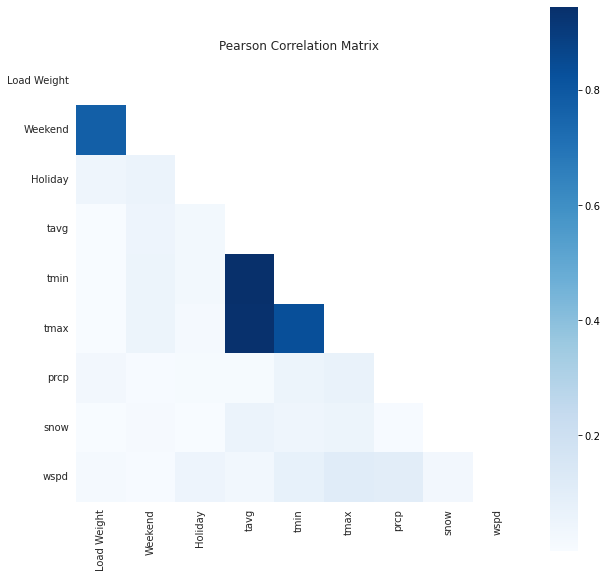

In [198]:
heatmap_pearson(train_data.corr(method='pearson').abs())

<b>The analysis on Correlation</b> 

It allows us to understand if we are getting the same information from diferent variables. In this case it is clear that all of the environmental variables are bringing the same information so we will only bring the Max temperature as it is the one with higher correlation with our target variable Load Weight

In [199]:
exogenousvar = exogvar.copy()
exogenousvar = exogenousvar.drop(['tmin','tavg'])

In [202]:
# define config lists
p_params = [0, 1, 2]
d_params = [0, 1]#, 2]
q_params = [0, 1]#, 2]
t_params = ['n','c','t','ct']
P_params = [0, 1, 2]
D_params = [0, 1]#, 2]
Q_params = [0, 1]#, 2]
m_params = [7]
models = list()
mapescore = list()
rmsescore = list()
# create config instances
for p in p_params:
    for d in d_params:
        for q in q_params:
            for t in t_params:
                for P in P_params:
                    for D in D_params:
                        for Q in Q_params:
                            for m in m_params:
                                mod = sm.tsa.statespace.SARIMAX(
                                                                train_data['Load Weight'], train_data[exogenousvar],
                                                                order=tuple([p,q,d]),
                                                                seasonal_order=tuple([P,Q,D,m]),
                                                                trend=t#,
                                                                #enforce_stationarity=True, 
                                                                #enforce_invertibility=True
                                                               )
                                res = mod.fit(disp=False)
                                #get the predictions and residuals
                                fcast = res.get_forecast(steps=len(test_data),exog=test_data[exogenousvar])
                                predictions = fcast.predicted_mean
                                predictions_error = pd.Series(fcast.predicted_mean.values,index= test_data.index)
                                residuals = test_data['Load Weight'] - predictions_error
                                MAPE = round(np.mean(abs(residuals/test_data['Load Weight'])),4)
                                RMSE = np.sqrt(np.mean(residuals**2))
                                methods = tuple([p,q,d]),tuple([P,Q,D,m]),t
                                #print('(p,q,d)(P,Q,D,12)(trend)',methods,'MAPE: ', MAPE, 'RMSE: ', RMSE)
                                models.append(methods)
                                mapescore.append(MAPE)
                                rmsescore.append(RMSE)

<b>GridSearch</b> 

This gridsearch was inspired by the on in the following link: https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/

In [203]:
zipped = list(zip(models, mapescore, rmsescore))
table = pd.DataFrame(zipped, columns=['Model', 'MAPE', 'RMSE'])
table.head()
table.describe()
table.sort_values(by='RMSE',ascending=True).head(25)

Model    MAPE           RMSE
59    ((0, 1, 0), (2, 1, 1, 7), n)  4.3550  458638.907408
83    ((0, 1, 0), (2, 1, 1, 7), t)  3.7875  458726.945297
503   ((2, 0, 1), (2, 1, 1, 7), c)  6.2135  459336.092963
79    ((0, 1, 0), (1, 1, 1, 7), t)  4.2368  460498.620111
499   ((2, 0, 1), (1, 1, 1, 7), c)  6.2805  460751.286655
147   ((0, 1, 1), (0, 1, 1, 7), n)  3.7622  461625.413451
495   ((2, 0, 1), (0, 1, 1, 7), c)  6.8777  461684.382938
531   ((2, 1, 1), (0, 1, 1, 7), n)  3.7897  461831.184338
339   ((1, 1, 1), (0, 1, 1, 7), n)  3.7035  461903.398514
55    ((0, 1, 0), (1, 1, 1, 7), n)  4.6603  462207.259014
155   ((0, 1, 1), (2, 1, 1, 7), n)  3.6331  462537.694094
68    ((0, 1, 0), (2, 0, 0, 7), c)  4.5739  462633.140899
56    ((0, 1, 0), (2, 0, 0, 7), n)  4.4272  463031.171569
80    ((0, 1, 0), (2, 0, 0, 7), t)  4.3855  463216.144174
51    ((0, 1, 0), (0, 1, 1, 7), n)  4.4373  463217.813355
539   ((2, 1, 1), (2, 1, 1, 7), n)  3.6719  463318.725495
527  ((2, 0, 1), (2, 1, 1, 7), ct)  6.2138  463426.264354
347   ((1, 1, 1), (2, 1, 1, 7), n)  3.5548  463426.830353
70    ((0, 1, 0), (2, 0, 1, 7), c)  4.5891  463478.064822
75    ((0, 1, 0), (0, 1, 1, 7), t)  4.0044  463576.860370
151   ((0, 1, 1), (1, 1, 1, 7), n)  3.6988  463594.212267
66    ((0, 1, 0), (1, 0, 1, 7), c)  4.7927  464029.335687
54    ((0, 1, 0), (1, 0, 1, 7), n)  4.6754  464055.420480
78    ((0, 1, 0), (1, 0, 1, 7), t)  4.6420  464108.509639
343   ((1, 1, 1), (1, 1, 1, 7), n)  3.6086  464284.367938

In [206]:
#sm.tsa.SARIMAX(df['Climate_Change'], order=(1,1,1))
my_order = (0, 1, 0)#(1, 0, 1) #(p,d,q) (AR,I,MA)
my_seasonal_order = (2, 1, 1, 7)#(2, 1, 2, 12)
trend = 'n' #'c'
'''A parameter for controlling a model of the deterministic trend as one of 
‘n’,’c’,’t’,’ct’ for no trend, constant, linear, and constant with linear trend, respectively.'''

mod = sm.tsa.statespace.SARIMAX(
                                train_data['Load Weight']
                                ,train_data[exogenousvar]
                                ,order=my_order
                                ,seasonal_order=my_seasonal_order
                                ,trend=trend
                                #,enforce_stationarity=True 
                                #,enforce_invertibility=True
                               )
res = mod.fit(disp=False)
print(res.summary())

#get the predictions and residuals
fcast = res.get_forecast(steps=len(test_data),exog=test_data[exogenousvar])
predictions = fcast.predicted_mean
predictions_error = pd.Series(fcast.predicted_mean.values,index= test_data.index)
residuals = test_data['Load Weight'] - predictions_error
MAPE = round(np.mean(abs(residuals/test_data['Load Weight'])),4)

                                      SARIMAX Results                                      
Dep. Variable:                         Load Weight   No. Observations:                 1799
Model:             SARIMAX(0, 1, 0)x(2, 1, [1], 7)   Log Likelihood              -26684.606
Date:                             Tue, 22 Mar 2022   AIC                          53389.211
Time:                                     23:50:56   BIC                          53444.117
Sample:                                          0   HQIC                         53409.484
                                            - 1799                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Weekend    -1.475e+06   3.06e+04    -48.210      0.000   -1.54e+06   -1.42e+06
Holiday     4.675e+05   7.4

In [205]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[train_start:test_end].index, y=df[train_start:test_end]['Load Weight'],
                    mode='lines',
                    name='TimeSeries'))
fig.add_trace(go.Scatter(x=predictions_error.index, y=predictions,
                    mode='lines',
                    name='Predictions'))
CI = fcast.conf_int()
fig.add_traces([go.Scatter(x = test_data.index, y = CI['lower Load Weight'],
                           mode = 'lines', line_color = 'rgba(0,0,0,0.2)',
                           showlegend = False),
                go.Scatter(x = test_data.index, y = CI['upper Load Weight'],
                           mode = 'lines', line_color = 'rgba(0,0,0,0.2)',
                           name = '95% confidence interval',
                           fill='tonexty', fillcolor = 'rgba(255, 0, 0, 0.1)')])

fig.update_layout(paper_bgcolor='rgba(255,255,255)', plot_bgcolor='rgba(0,0,0,0)')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black',rangemode="tozero")
fig.update_xaxes(showgrid=True, gridwidth=0.1, gridcolor='lightskyblue')
#fig.update_yaxes(showgrid=True, gridwidth=0.1, gridcolor='lightskyblue')

fig.show()

print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data['Load Weight'])),4))

print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Mean Absolute Percent Error: 7.0455
Root Mean Squared Error: 481167.7295848262


<b>SARIMA MODEL</b> 

Following the result of the gridsearch, we performed the forecast for the following month.

In [207]:
ModelAnalysis = pd.DataFrame()
ModelAnalysis['Models'] = ['MAPE','RMSE']

In [208]:
ModelAnalysis['SARIMA'] = [
                 round(np.mean(abs(residuals/test_data['Load Weight'])),4),
                 np.sqrt(np.mean(residuals**2))]

In [209]:
ModelAnalysis

Models         SARIMA
0   MAPE       4.355000
1   RMSE  458638.907408

# BASELINE MODELS 4 Comparison


### LINEAR REGRESSION

In [210]:
# Linear Regression

mod = sm.OLS(train_data['Load Weight'], train_data[exogvar])
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:            Load Weight   R-squared (uncentered):                   0.877
Model:                            OLS   Adj. R-squared (uncentered):              0.876
Method:                 Least Squares   F-statistic:                              1589.
Date:                Tue, 22 Mar 2022   Prob (F-statistic):                        0.00
Time:                        23:51:31   Log-Likelihood:                         -26526.
No. Observations:                1799   AIC:                                  5.307e+04
Df Residuals:                    1791   BIC:                                  5.311e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [211]:
print("Parameters: ", res.params)
print("R2: ", res.rsquared)

Parameters:  Weekend   -1.335251e+06
Holiday    1.782812e+05
tavg      -2.442984e+04
tmin      -3.639791e+04
tmax       8.136638e+04
prcp       2.096135e+03
snow       1.778635e+04
wspd       4.503748e+04
dtype: float64
R2:  0.8765231988872731


In [213]:
#get the predictions and residuals
fcast = res.get_prediction(exog=test_data[exogvar])
predictions = pd.Series(fcast.predicted_mean,index= test_data.index)
predictions_error = pd.Series(predictions,index= test_data.index)
residuals = test_data['Load Weight'] - predictions_error

In [219]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[train_start:test_end].index, y=df[train_start:test_end]['Load Weight'],
                    mode='lines',
                    name='TimeSeries'))
fig.add_trace(go.Scatter(x=predictions_error.index, y=predictions,
                    mode='lines',
                    name='Predictions'))
CI = fcast.conf_int(alpha = .05)
fig.add_traces([go.Scatter(x = predictions_error.index, y = CI[:,0],
                           mode = 'lines', line_color = 'rgba(0,0,0,0.2)',
                           showlegend = False),
                go.Scatter(x = predictions_error.index, y = CI[:,1],
                           mode = 'lines', line_color = 'rgba(0,0,0,0.2)',
                           name = '95% confidence interval',
                           fill='tonexty', fillcolor = 'rgba(255, 0, 0, 0.1)')])

fig.update_layout(paper_bgcolor='rgba(255,255,255)', plot_bgcolor='rgba(0,0,0,0)')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black',rangemode="tozero")
fig.update_xaxes(showgrid=True, gridwidth=0.1, gridcolor='lightskyblue')
#fig.update_yaxes(showgrid=True, gridwidth=0.1, gridcolor='lightskyblue')

fig.show()

print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data['Load Weight'])),4))

print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Mean Absolute Percent Error: 7.8024
Root Mean Squared Error: 595290.2682048468


In [220]:
ModelAnalysis['Linear Regression'] = [
                 round(np.mean(abs(residuals/test_data['Load Weight'])),4),
                 np.sqrt(np.mean(residuals**2))]

In [221]:
ModelAnalysis

Models         SARIMA  Linear Regression
0   MAPE       4.355000           7.802400
1   RMSE  458638.907408      595290.268205

### MEAN METHOD

In [223]:
#get the predictions and residuals
fcast = df[train_start:train_end]['Load Weight'].mean()
predictions = pd.Series(df[train_start:train_end]['Load Weight'].mean(),index=test_data.index)
predictions_error = pd.Series(predictions,index= test_data.index)
residuals = test_data['Load Weight'] - predictions_error

In [224]:
predictions_min = pd.Series(df[train_start:train_end]['Load Weight'].min(),index= test_data.index)
predictions_max = pd.Series(df[train_start:train_end]['Load Weight'].max(),index= test_data.index)

In [226]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[train_start:test_end].index, y=df[train_start:test_end]['Load Weight'],
                    mode='lines',
                    name='TimeSeries'))
fig.add_trace(go.Scatter(x=test_data.index, y=predictions,
                    mode='lines',
                    name='Predictions'))
#CI = fcast.conf_int(alpha = .1)
fig.add_traces([go.Scatter(x = test_data.index, y = predictions_min,
                          mode = 'lines', line_color = 'rgba(0,0,0,0.2)',
                           showlegend = False),
                go.Scatter(x = test_data.index, y = predictions_max,
                           mode = 'lines', line_color = 'rgba(0,0,0,0.2)',
                           name = 'Min-Max confidence interval',
                           fill='tonexty', fillcolor = 'rgba(255, 0, 0, 0.1)')])

fig.update_layout(paper_bgcolor='rgba(255,255,255)', plot_bgcolor='rgba(0,0,0,0)')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black',rangemode="tozero")
fig.update_xaxes(showgrid=True, gridwidth=0.1, gridcolor='lightskyblue')
#fig.update_yaxes(showgrid=True, gridwidth=0.1, gridcolor='lightskyblue')

fig.show()

print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data['Load Weight'])),4))

print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Mean Absolute Percent Error: 20.5794
Root Mean Squared Error: 764517.2242315614


In [227]:
ModelAnalysis['Mean'] = [
                 round(np.mean(abs(residuals/test_data['Load Weight'])),4),
                 np.sqrt(np.mean(residuals**2))]

In [228]:
ModelAnalysis

Models         SARIMA  Linear Regression           Mean
0   MAPE       4.355000           7.802400      20.579400
1   RMSE  458638.907408      595290.268205  764517.224232

## PROPHET

<b>PROPHET MODEL</b> 

Additionally we tried out facebook's prophet model as to better understand the efficacy of our model. And if possible improve upon the results we have got so far

In [231]:
prophetdf = df.reset_index()[['Report Date','Load Weight']].rename(columns={"Report Date": "ds", "Load Weight": "y"})

In [232]:
# load data
prophetdf = df.reset_index()[['Report Date','Load Weight']].rename(columns={"Report Date": "ds", "Load Weight": "y"})
# prepare expected column names
prophetdf.columns = ['ds', 'y']
prophetdf['ds']= to_datetime(prophetdf['ds'])
# define the model
model = Prophet()
# fit the model
model.fit(prophetdf)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [238]:
# define the period for which we want a prediction
future = pd.DataFrame(test_data.index)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])

In [239]:
# use the model to make a forecast
forecast = model.predict(future)
forecast.head()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2020-07-31  1.508077e+06  1.152320e+06  1.867579e+06  1.508077e+06   
1 2020-08-01  1.508600e+06 -2.853265e+05  4.289433e+05  1.508600e+06   
2 2020-08-03  1.509644e+06  1.862860e+06  2.541246e+06  1.509644e+06   
3 2020-08-04  1.510166e+06  1.314742e+06  1.974433e+06  1.510166e+06   
4 2020-08-05  1.510688e+06  1.721091e+06  2.408837e+06  1.510688e+06   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  1.508077e+06    3.329311e+03          3.329311e+03          3.329311e+03   
1  1.508600e+06   -1.427400e+06         -1.427400e+06         -1.427400e+06   
2  1.509644e+06    6.885219e+05          6.885219e+05          6.885219e+05   
3  1.510166e+06    1.417038e+05          1.417038e+05          1.417038e+05   
4  1.510688e+06    5.537038e+05          5.537038e+05          5.537038e+05   

         weekly  weekly_lower  weekly_upper         yearly   yearly_lower  \
0  1.765254e+05  1.765254e+05  1.765254e+05 -173196.109144 -173196.109144   
1 -1.249231e+06 -1.249231e+06 -1.249231e+06 -178168.929160 -178168.929160   
2  8.736250e+05  8.736250e+05  8.736250e+05 -185103.070945 -185103.070945   
3  3.287362e+05  3.287362e+05  3.287362e+05 -187032.400033 -187032.400033   
4  7.416560e+05  7.416560e+05  7.416560e+05 -187952.268919 -187952.268919   

    yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0 -173196.109144                   0.0                         0.0   
1 -178168.929160                   0.0                         0.0   
2 -185103.070945                   0.0                         0.0   
3 -187032.400033                   0.0                         0.0   
4 -187952.268919                   0.0                         0.0   

   multiplicative_terms_upper          yhat  
0                         0.0  1.511407e+06  
1                         0.0  8.119923e+04  
2                         0.0  2.198166e+06  
3                         0.0  1.651869e+06  
4                         0.0  2.064391e+06

In [240]:
#get the predictions and residuals
fcast = forecast.set_index('ds').yhat
predictions = pd.Series(fcast,index= test_data.index)
residuals = test_data['Load Weight'] - predictions

In [241]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[train_start:test_end].index, y=df[train_start:test_end]['Load Weight'],
                    mode='lines',
                    name='TimeSeries'))
fig.add_trace(go.Scatter(x=test_data.index, y=forecast.yhat,
                    mode='lines',
                    name='Predictions'))
fig.add_traces([go.Scatter(x = test_data.index, y = forecast.yhat_lower,
                           mode = 'lines', line_color = 'rgba(0,0,0,0.2)',
                           showlegend = False),
                go.Scatter(x = test_data.index, y = forecast.yhat_upper,
                           mode = 'lines', line_color = 'rgba(0,0,0,0.2)',
                           name = '95% confidence interval',
                           fill='tonexty', fillcolor = 'rgba(255, 0, 0, 0.1)')])

fig.update_layout(paper_bgcolor='rgba(255,255,255)', plot_bgcolor='rgba(0,0,0,0)')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black',rangemode="tozero")
fig.update_xaxes(showgrid=True, gridwidth=0.1, gridcolor='lightskyblue')
#fig.update_yaxes(showgrid=True, gridwidth=0.1, gridcolor='lightskyblue')

fig.show()

print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data['Load Weight'])),4))

print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Mean Absolute Percent Error: 1.3696
Root Mean Squared Error: 131669.77084560748


In [242]:
ModelAnalysis['Prophet'] = [
                 round(np.mean(abs(residuals/test_data['Load Weight'])),4),
                 np.sqrt(np.mean(residuals**2))]

# CONCLUSION

In [243]:
Analysis = ModelAnalysis.copy()
Analysis = Analysis.T.reset_index()[1:]
Analysis.columns = ModelAnalysis.T.reset_index().iloc[0] 

Analysis.head()

0             Models     MAPE           RMSE
1             SARIMA    4.355  458638.907408
2  Linear Regression   7.8024  595290.268205
3               Mean  20.5794  764517.224232
4            Prophet   1.3696  131669.770846